# Fitting an optimal APD to EBSD data

In [1]:
!pip install PyAPD -U

In [1]:
# SETUP:

# first import the whole package
import PyAPD

# then load all the functions in the .py files in the .../PyAPD/ directory:
from PyAPD import *

import copy

torch.set_printoptions(precision=10) # show more digits

device = "cuda" if torch.cuda.is_available() else "cpu"
dt = torch.float64
torch.set_default_dtype(dt)

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


In [2]:
# helper functions

# custom scatter matrix plot
def custom_scatter_matrix_plot(TV,ratios,angles):

    fig, axes = plt.subplots(3,3,figsize=(10.5, 10.5))


    # TV vs ratios
    xy = np.vstack([TV,ratios])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = TV[idx], ratios[idx], z[idx]


    wtf = axes[1,0].scatter(x, y, c=z, s=50,cmap=cm)
    


    # ratios vs TV
    xy = np.vstack([ratios,TV])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = ratios[idx], TV[idx], z[idx]

    wtf = axes[0,1].scatter(x, y, c=z, s=50,cmap=cm)
    #fig.colorbar(wtf)



    # TV vs angles
    xy = np.vstack([TV,angles])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = TV[idx], angles[idx], z[idx]

    wtf = axes[2,0].scatter(x, y, c=z, s=50,cmap=cm)
    #fig.colorbar(wtf)


    # angles vs TV
    xy = np.vstack([angles,TV])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = angles[idx], TV[idx], z[idx]

    wtf = axes[0,2].scatter(x, y, c=z, s=50,cmap=cm)
    #fig.colorbar(wtf)


    # angles vs ratios
    xy = np.vstack([angles,ratios])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = angles[idx], ratios[idx], z[idx]

    wtf = axes[1,2].scatter(x, y, c=z, s=50,cmap=cm)
    #fig.colorbar(wtf)


    # ratios vs angles
    xy = np.vstack([ratios,angles])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = ratios[idx], angles[idx], z[idx]

    wtf = axes[2,1].scatter(x, y, c=z, s=50,cmap=cm)
    #fig.colorbar(wtf)


    # histograms:
    Y,X = np.histogram(TV, 25, density=0)
    # x_span = X.max()-X.min()
    # C = [cm(((x-X.min())/x_span)) for x in X]
    Y_span = Y.max()-Y.min()
    C = [cm(((y-Y.min())/Y_span)) for y in Y]
    axes[0,0].bar(X[:-1],Y,color=C,width=X[1]-X[0])


    Y,X = np.histogram(ratios, 25, density=0)
    Y_span = Y.max()-Y.min()
    C = [cm(((y-Y.min())/Y_span)) for y in Y]
    axes[1,1].bar(X[:-1],Y,color=C,width=X[1]-X[0])

    Y,X = np.histogram(angles, 25, density=0)
    Y_span = Y.max()-Y.min()
    C = [cm(((y-Y.min())/Y_span)) for y in Y]
    axes[2,2].bar(X[:-1],Y,color=C,width=X[1]-X[0])
    
    axes[2,0].set_xlabel('Grain area')
    axes[2,1].set_xlabel('Ellipse aspect ratio')
    axes[2,2].set_xlabel('Ellipse angle')
    
    axes[0,0].set_ylabel('Grain area')
    axes[1,0].set_ylabel('Ellipse aspect ratio')
    axes[2,0].set_ylabel('Ellipse angle')



    for ax in axes.flatten():
        ax.set_rasterized(True)
        ax.xaxis.label.set_rotation(0)
        ax.xaxis.label.set_size(20)
        ax.yaxis.label.set_size(20)
        ax.yaxis.label.set_rotation(90)
        ax.yaxis.label.set_ha('center')
        ax.get_yaxis().set_label_coords(-0.2,0.5)
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(12) 
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(12) 

        ax.xaxis.label.set_ha('center')
        ax.get_xaxis().set_label_coords(0.5,-0.1)
        
        
        
    axes[0,0].get_xaxis().set_visible(False)
    axes[1,0].get_xaxis().set_visible(False)

    axes[0,1].get_xaxis().set_visible(False)
    axes[1,1].get_xaxis().set_visible(False)
    
    axes[0,2].get_xaxis().set_visible(False)
    axes[1,2].get_xaxis().set_visible(False)
    
    
    
    axes[0,1].get_yaxis().set_visible(False)
    axes[0,2].get_yaxis().set_visible(False)

    axes[1,1].get_yaxis().set_visible(False)
    axes[1,2].get_yaxis().set_visible(False)
    
    axes[2,1].get_yaxis().set_visible(False)
    axes[2,2].get_yaxis().set_visible(False)


    plt.tight_layout()
    plt.gcf().subplots_adjust(wspace=0.05, hspace=0.05)
    return fig


#Kolmogorov-Smirnov test for 1D data and a marginal distribution
def ks_testing(data,marg):
    sample = ot.Sample([[data[i]] for i in range(len(TV))])
    return ot.FittingTest.Kolmogorov(sample, marg)
#Kolmogorov-Smirnov test whether two samples came from the same distributions
def ks_testing_2_sample(data1,data2):
    sample1 = ot.Sample([[data1[i]] for i in range(len(TV))])
    sample2 = ot.Sample([[data2[i]] for i in range(len(TV))])
    return ot.HypothesisTest.TwoSamplesKolmogorov(sample1, sample2)

# plot of data histogram and the corresponding marginal dist
def plot_marg_hist(data,marg):
    sample = ot.Sample([[data[i]] for i in range(len(TV))])
    histo = ot.HistogramFactory().build(sample).drawPDF()
    graph = marg.drawPDF()
    graph.add(histo)
    graph.setLegends(['KS dist', 'hist'])
    View(graph)
# plot data histograms to compare
def plot_hist_2_sample(data1,data2):
    sample1 = ot.Sample([[data1[i]] for i in range(len(TV))])
    sample2 = ot.Sample([[data2[i]] for i in range(len(TV))])
    
    graph = ot.HistogramFactory().build(sample1).drawPDF()
    graph.setColors(["red"])
    histo2 = ot.HistogramFactory().build(sample2).drawPDF()
    graph.add(histo2)
    graph.setLegends(['hist1', 'hist2'])
    View(graph)


In [5]:
# Load the grain file:

file = "../../../../data/2D_Tata_Steel_paper_example/sample_lc_steel_grain_file_final.txt"
seed_id = (0,1)
volumes_id = (5)
orientation_id = (2,3,4)

X, A, TV, EBSD = load_setup_from_EBSD_data_2D(file = file,
                                             seed_id = seed_id,
                                             volumes_id = volumes_id,
                                             orientation_id = orientation_id,
                                             normalise_matrices = True,
                                             angle_in_degrees = False,
                                             device = device,
                                             dt = dt)
X = X.to(device,dtype=dt)
A = A.to(device,dtype=dt)
TV = TV.to(device,dtype=dt)
N, D = X.shape

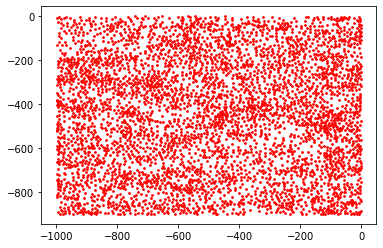

In [6]:
# Plot the seeds:
plt.scatter(X[:,0].cpu().numpy(),X[:,1].cpu().numpy(),c='r',s=3)

In [7]:
# Manually enter the correct domain size:
dom_x = [-999.02675,0.49975]
dom_y = [-901.0003,0.5003]
domain = torch.tensor([dom_x,dom_y])

In [8]:
# Compute total area and show largest and smallest grain:
total_area = TV.sum()
print("Largest grain: ", torch.max(TV).cpu().numpy(), "Smallest grain: ",torch.min(TV).cpu().numpy())

Largest grain:  2073.79661128761 Smallest grain:  11.000898081641


In [9]:
# Construct an APD system:
apd1 = apd_system(D=2,
                  domain = domain,
                  X = X,
                  As = A,
                  heuristic_W = True, # the default set of weights is the heuristic guess
                  target_masses = TV/total_area,
                  dt = torch.float64,
                  device = device,
                  pixel_size_prefactor = 1.0,
                  error_tolerance = 0.01
                  )

In [10]:
# Check number of grains
apd1.N

4587

In [11]:
# Check pixel parameters
apd1.pixel_params

(2863, 2863)

In [12]:
# Compute domain length ratio for plots
len_x = dom_x[1] - dom_x[0]
len_y = dom_y[1] - dom_y[0]

ratio = len_x / len_y

# Fitting distributions and generating artificial microstructure

In [33]:
# SETUP

colors = [(230/255,97/255,1/255),
(253/255,184/255,99/255),
(178/255,171/255,210/255),
(94/255,60/255,153/255)]

#cm = plt.cm.get_cmap('RdYlBu')
cm = plt.cm.get_cmap('plasma')

import scipy
import scipy.stats
from scipy.stats import gaussian_kde
import openturns as ot
from openturns.viewer import View

#import pandas as pd

/tmp/ipykernel_100803/1470927839.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('plasma')


In [34]:
ratios = (EBSD[:,orientation_id[0]]/EBSD[:,orientation_id[1]])
angles = (EBSD[:,orientation_id[-1]]).cpu().numpy()

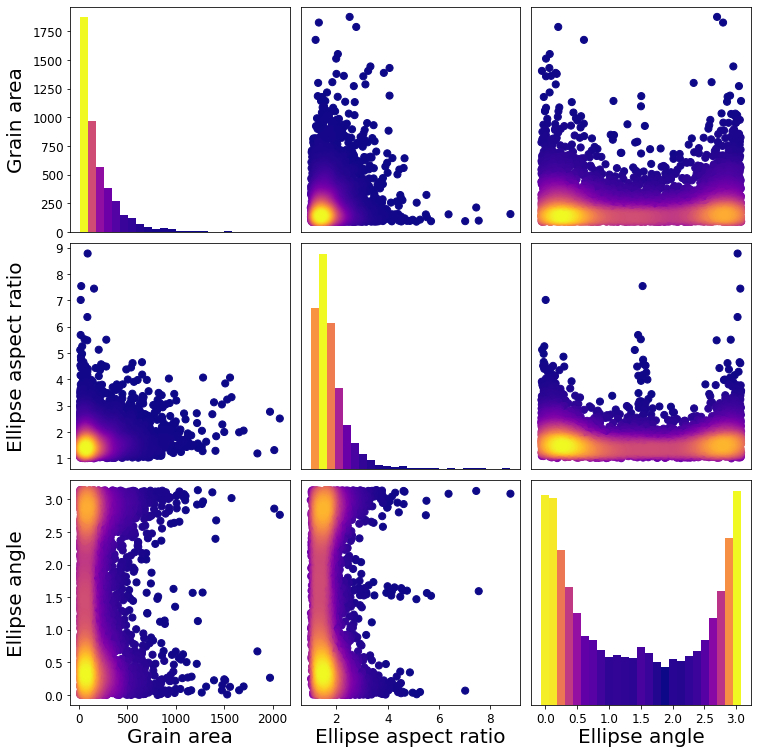

In [35]:
fig = custom_scatter_matrix_plot(TV,ratios,angles);

In [36]:
# Use kernel smoothing approach to sampling

data_for_ot = [[TV[i], ratios[i], angles[i]] for i in range(len(TV))]
kernel = ot.Uniform()
ks = ot.KernelSmoothing(kernel)
#ks = ot.KernelSmoothing()
bandwidth = [1.0,0.05,0.01]

fittedDist = ks.build(data_for_ot)
fittedDist = ks.build(data_for_ot,bandwidth)

In [37]:
# get marginal distributions
marg0 = fittedDist.getMarginal(0)
marg1 = fittedDist.getMarginal(1)
marg2 = fittedDist.getMarginal(2)

In [38]:
ks_testing(angles,marg2)

class=TestResult name=Unnamed type=Kolmogorov KernelMixture binaryQualityMeasure=true p-value threshold=0.05 p-value=1 statistic=0.00252939 description=[KernelMixture(kernel = Uniform(a = -1, b = 1), bandwidth = [0.01], sample = 
   0 : [ 1.58712 ]
   1 : [ 1.57096 ]
   2 : [ 1.4533  ]
...
4584 : [ 1.32716 ]
4585 : [ 1.07646 ]
4586 : [ 2.88167 ] vs sample Unnamed]

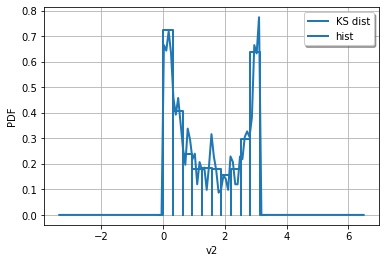

In [39]:
plot_marg_hist(angles,marg2)

In [40]:
# Fix random seed
seed = 50

ot.RandomGenerator.SetSeed(seed)

sample = fittedDist.getSample(apd1.N)
np_sample = np.array(sample)

# Adjustments to make the artificial data physically relevant
#np_sample[:,0] = np_sample[:,0] - np_sample[:,0].min() + 1.0
#shift = 1.0 - np_sample[:,1].min()
#np_sample[:,1] = np_sample[:,1] + shift

In [41]:
TV_art = torch.tensor(np_sample[:,0])
TV_art_norm = TV_art / TV_art.sum()
ratios_art = torch.tensor(np_sample[:,1])
angles_art = torch.tensor(np_sample[:,2])
# # Take circularity of the angles into account
# thetas_art[thetas_art > np.pi] -= np.pi
# thetas_art[thetas_art < 0.0] += np.pi

# np_sample[:,2] = np.array(thetas)

In [42]:
len(np_sample)

4587

In [43]:
ks_testing(angles_art,marg2)

class=TestResult name=Unnamed type=Kolmogorov KernelMixture binaryQualityMeasure=true p-value threshold=0.05 p-value=0.260731 statistic=0.0148581 description=[KernelMixture(kernel = Uniform(a = -1, b = 1), bandwidth = [0.01], sample = 
   0 : [ 1.58712 ]
   1 : [ 1.57096 ]
   2 : [ 1.4533  ]
...
4584 : [ 1.32716 ]
4585 : [ 1.07646 ]
4586 : [ 2.88167 ] vs sample Unnamed]

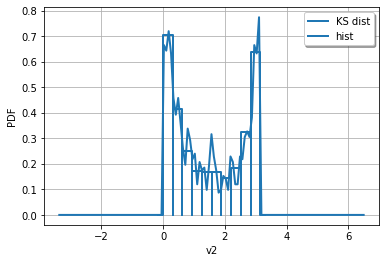

In [44]:
plot_marg_hist(angles_art,marg2)

In [45]:
print(ks_testing_2_sample(TV,TV_art))
print(ks_testing_2_sample(ratios,ratios_art))
print(ks_testing_2_sample(angles,angles_art))

class=TestResult name=Unnamed type=TwoSamplesKolmogorov binaryQualityMeasure=true p-value threshold=0.05 p-value=0.973461 statistic=0.0100283 description=[sampleUnnamed vs sample Unnamed]
class=TestResult name=Unnamed type=TwoSamplesKolmogorov binaryQualityMeasure=true p-value threshold=0.05 p-value=0.967611 statistic=0.0102463 description=[sampleUnnamed vs sample Unnamed]
class=TestResult name=Unnamed type=TwoSamplesKolmogorov binaryQualityMeasure=true p-value threshold=0.05 p-value=0.706434 statistic=0.0146065 description=[sampleUnnamed vs sample Unnamed]


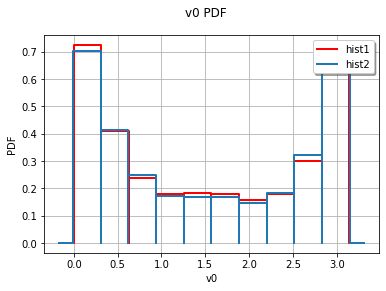

In [46]:
plot_hist_2_sample(angles,angles_art)

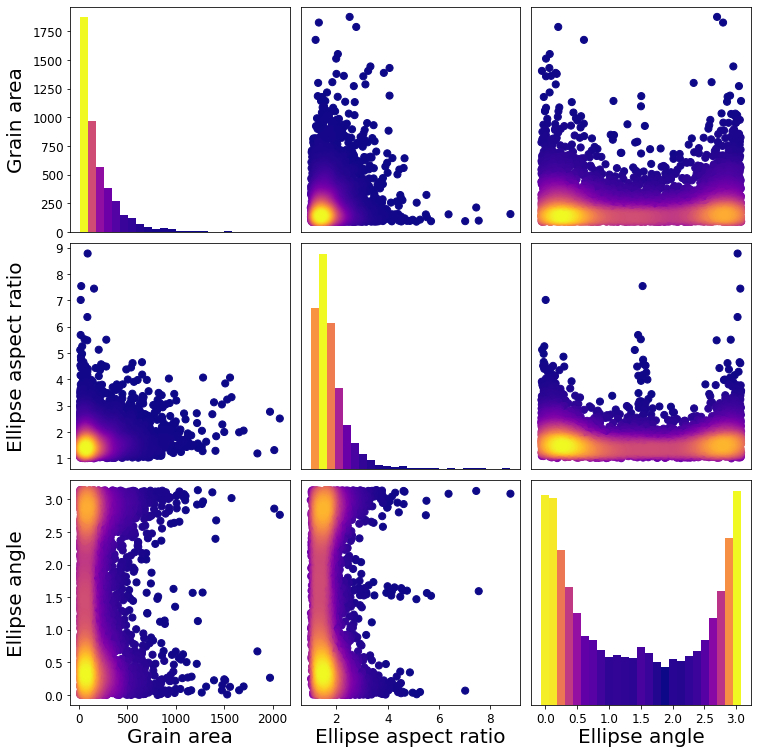

In [47]:
fig = custom_scatter_matrix_plot(TV,ratios,angles);
#plt.savefig('ebsd_scatter_matrix_plot_custom.pdf',dpi=300)  

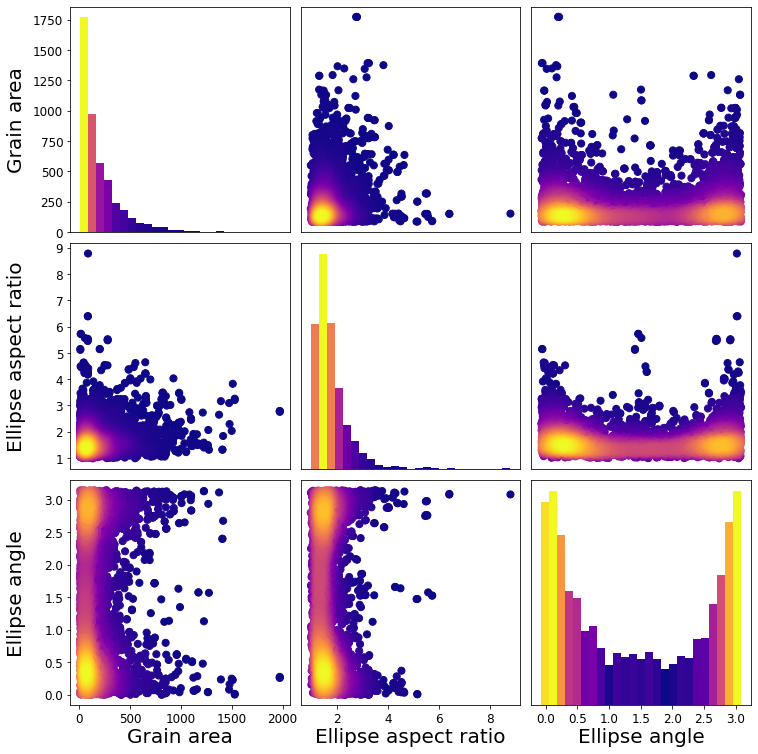

In [48]:
fig_art = custom_scatter_matrix_plot(TV_art,ratios_art,angles_art);
#plt.savefig('ebsd_scatter_matrix_plot_artificial_custom.pdf',dpi=300)  

In [67]:
# Prepare data to be passed to the APD system
a_s = torch.sqrt(ratios_art)
b_s = 1.0/a_s

ss = torch.sin(thetas_art)
cc = torch.cos(thetas_art)
rots = torch.stack([torch.stack([cc, -ss],dim=1),
                    torch.stack([ss, cc], dim=1)],dim=2)
IIs = torch.stack([torch.stack([1/a_s**2,torch.tensor([0.0]*N)],dim=1),
                  torch.stack([torch.tensor([0.0]*N),1/b_s**2],dim=1)],dim=2)
As = rots @ IIs @ torch.transpose(rots,1,2)

In [68]:
# Random sample of seed points
apd1.radius_of_exclusion = 0.2
torch.manual_seed(seed)
X = sample_seeds_with_exclusion(apd1.N,dim=apd1.D,
                                radius_prefactor = apd1.radius_of_exclusion,
                                verbose=True)

X = apd1.domain[:,0] + (apd1.domain[:,1]-apd1.domain[:,0]) * X.to(device=apd1.device, dtype = apd1.dt)

347 proposed seed points have been excluded.


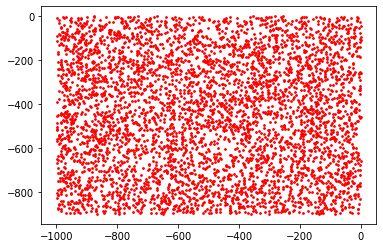

In [69]:
# Plot the seed points
plt.scatter(X[:,0].cpu().numpy(),X[:,1].cpu().numpy(),c='r',s=3)

In [70]:
# Pass data to the APD system
apd1.set_X(X = X)
apd1.set_As(As = As)
apd1.set_target_masses(target_masses = TV_art_norm)
apd1.set_W(W=torch.zeros(apd1.N).to(device=apd1.device,dtype=apd1.dt))
apd1.error_tolerance = 0.1
apd1.set_pixel_params()
apd1.assemble_pixels()
apd1.check_optimality()

Precision loss detected!
Percentage error =  3971.131640390969


In [71]:
# Check pixel params
apd1.pixel_params

(953, 953)

In [36]:
# Find first optimal set of weights
apd1.find_optimal_W()

Solver tolerance is with respect to each grain separately.
Smallest tol:  tensor(0.0731003237, device='cuda:0')
Optimality condition successfully overwritten.
Optimization terminated successfully.
         Current function value: -225072065.666975
         Iterations: 461
         Function evaluations: 472
It took 92.76692748069763 seconds to find optimal W.


In [37]:
# Check optimality
apd1.check_optimality()

The APD is optimal!
Percentage error =  9.952987342437785


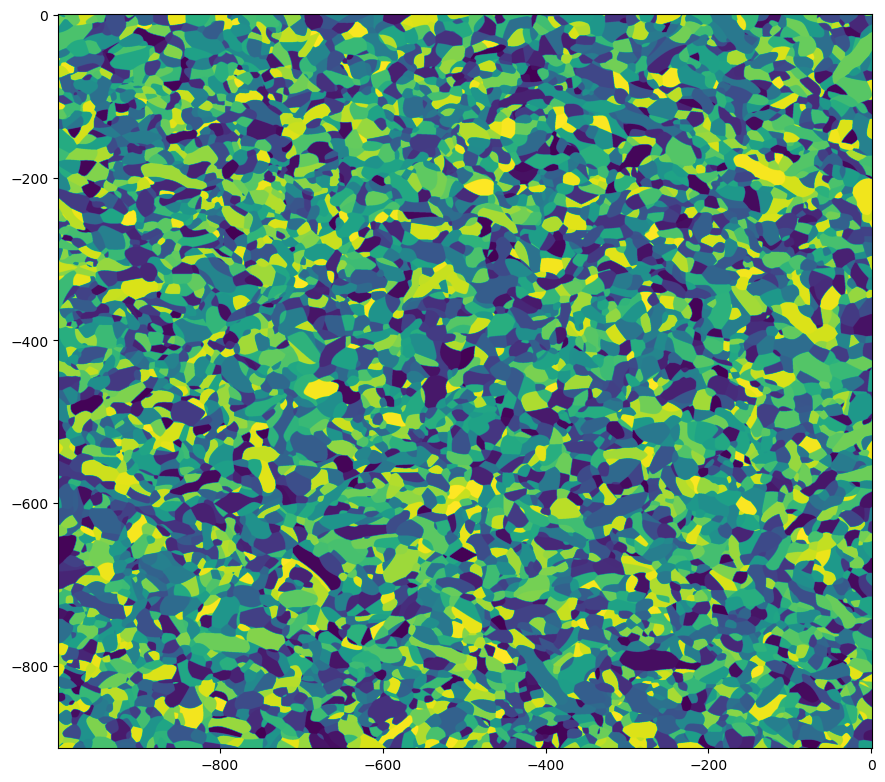

In [38]:
# Plot the resulting APD
fig1, ax1 = apd1.plot_apd()

In [39]:
# Regularise it by running 5 iterations of the Lloyds algorithm
apd1.Lloyds_algorithm(K=5,verbosity_level = 2)

Lloyds iteration: 0
Solver tolerance is with respect to each grain separately.
Smallest tol:  tensor(0.0731003237, device='cuda:0')
Optimality condition successfully overwritten.
Optimization terminated successfully.
         Current function value: -225072068.533288
         Iterations: 1
         Function evaluations: 3
It took 0.5274748802185059 seconds to find optimal W.
The APD is optimal!
Percentage error =  9.952987342437785
Lloyds iteration: 1
Solver tolerance is with respect to each grain separately.
Smallest tol:  tensor(0.0731003237, device='cuda:0')
Optimality condition successfully overwritten.
Optimization terminated successfully.
         Current function value: -58300971.661033
         Iterations: 329
         Function evaluations: 341
It took 67.17029213905334 seconds to find optimal W.
The APD is optimal!
Percentage error =  4.740821955122725
Lloyds iteration: 2
Solver tolerance is with respect to each grain separately.
Smallest tol:  tensor(0.0731003237, device='cud

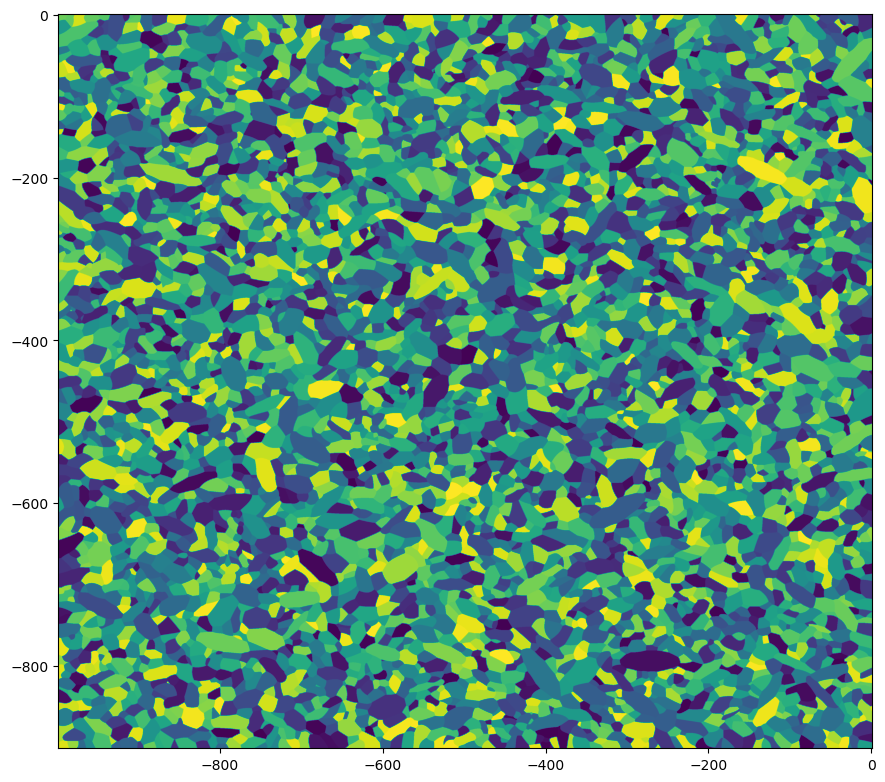

In [40]:
# Plot the resulting APD
fig2, ax2 = apd1.plot_apd()

In [41]:
# Lower the error tolerance, leading to a refined mesh of pixels
apd1.error_tolerance = 0.05
apd1.set_pixel_params()
apd1.assemble_pixels()
apd1.pixel_params

(4965, 4965)

In [42]:
# Solve again
apd1.find_optimal_W()

Solver tolerance is with respect to each grain separately.
Smallest tol:  tensor(0.0365501618, device='cuda:0')
Optimality condition successfully overwritten.
Optimization terminated successfully.
         Current function value: -49757471.196797
         Iterations: 88
         Function evaluations: 93
It took 33.89867377281189 seconds to find optimal W.


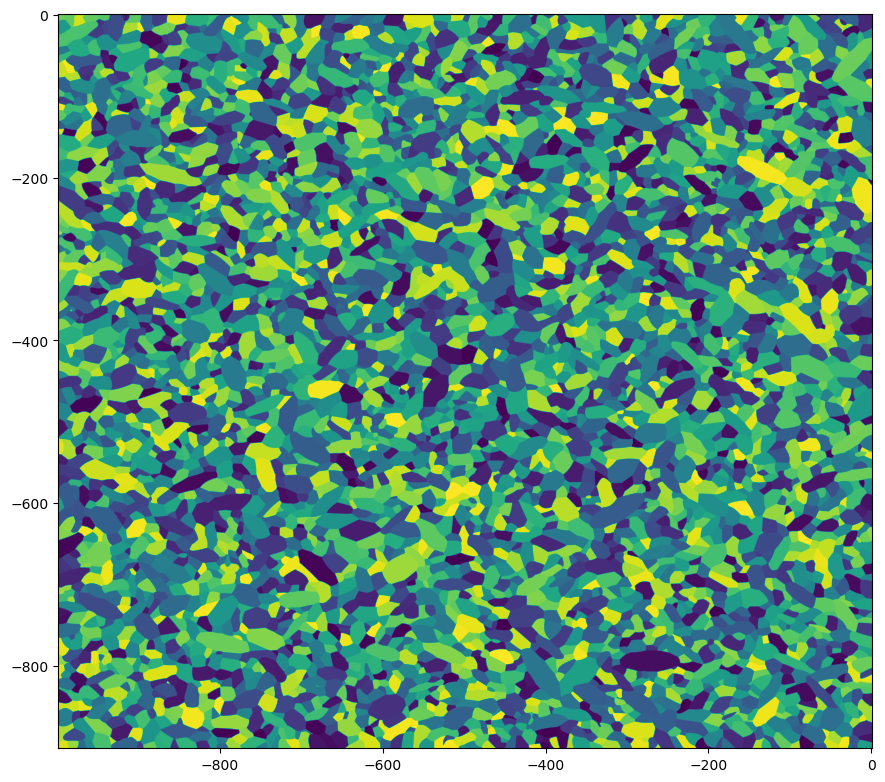

In [43]:
# Plot the resulting APD
fig3, ax3 = apd1.plot_apd()

Solver tolerance is with respect to each grain separately.
Smallest tol:  tensor(0.0146200647, device='cuda:0')
Optimality condition successfully overwritten.
Optimization terminated successfully.
         Current function value: -49757772.800762
         Iterations: 55
         Function evaluations: 58
It took 50.43124580383301 seconds to find optimal W.


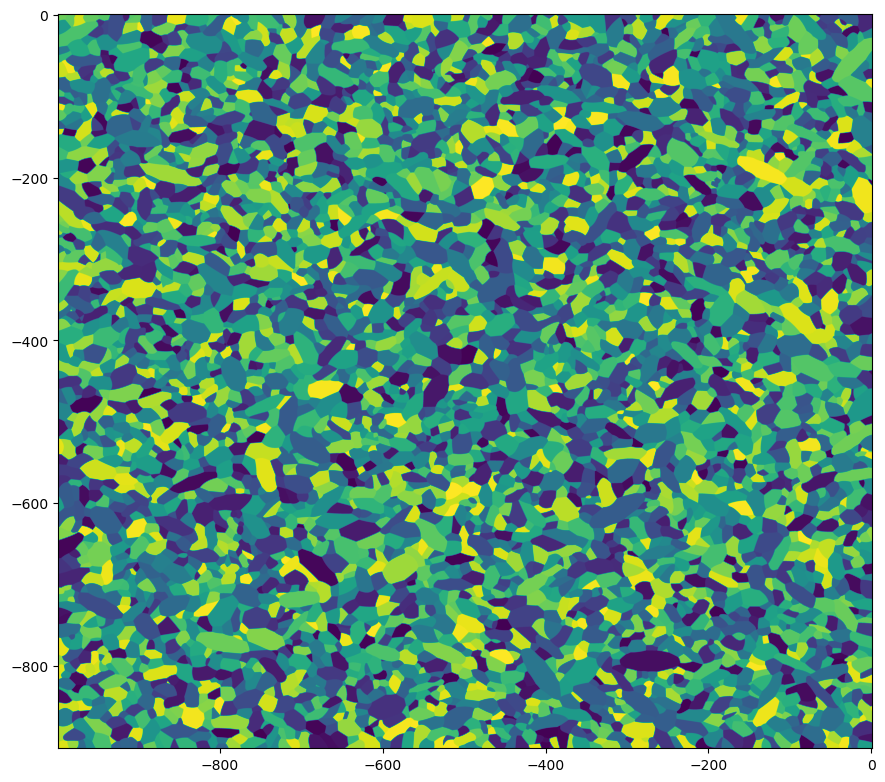

In [44]:
# One final time:
apd1.error_tolerance = 0.02
apd1.set_pixel_params()
apd1.assemble_pixels()
apd1.pixel_params

apd1.find_optimal_W()

fig4, ax4 = apd1.plot_apd()

In [45]:
# Check optimality
apd1.check_optimality()

The APD is optimal!
Percentage error =  1.7014864161185002


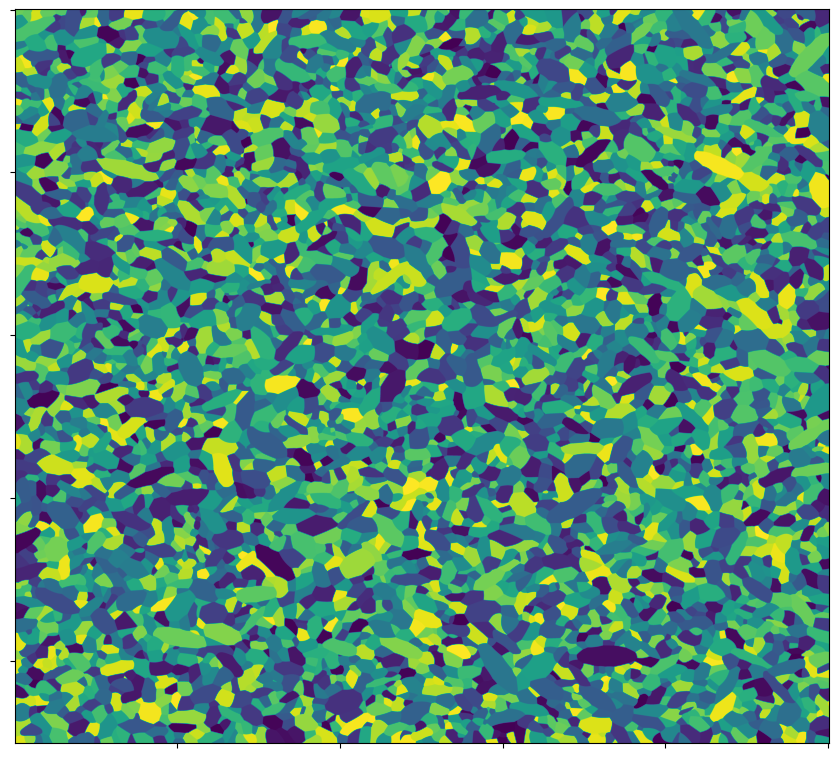

In [46]:
# Save the figure
ax4.set_xticklabels([])
ax4.set_yticklabels([])

fig.set_size_inches(ratio*10.5, 10.5, forward=True)
fig4.savefig('artificial_apd_final.pdf')
fig4